This unit runs through the API for common tasks in machine learning. Refer to the links in each section to dive deeper.

## Working with data
PyTorch has two primitives to work with data: ``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``. ``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around the ``Dataset``.



In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

PyTorch offers domain-specific libraries such as `TorchText`, `TorchVision`, and `TorchAudio`, all of which include datasets. For this tutorial, we  will be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like CIFAR and COCO. In this tutorial, we'll use the **FashionMNIST** dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and ``target_transform`` to modify the samples and labels respectively.

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.



Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


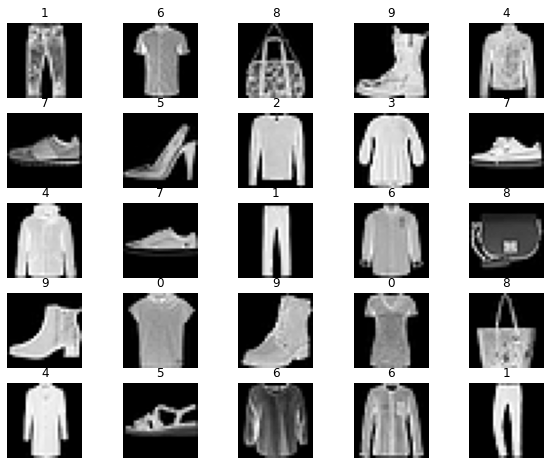

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break
    
# Display sample data
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Creating models
To define a neural network in PyTorch, we create a class that inherits from `nn.Module`. We define the layers of the network in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate operations in the neural network, we move it to the GPU if available.



In [8]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


## Optimizing the Model Parameters
To train a model, we need a loss function and an optimizer.  We'll be using `nn.CrossEntropyLoss` for loss and `Stochastic Gradient Descent` for optimization.

In [9]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and back-propagates the prediction error to adjust the model's parameters. 



In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We can also check the model's performance against the test dataset to ensure it is learning.


In [11]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the accuracy increase and the loss decrease with every epoch.



In [12]:
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 2.297887  [    0/60000]
loss: 2.289075  [ 6400/60000]
loss: 2.277790  [12800/60000]
loss: 2.274850  [19200/60000]
loss: 2.273616  [25600/60000]
loss: 2.259653  [32000/60000]
loss: 2.259051  [38400/60000]
loss: 2.251090  [44800/60000]
loss: 2.218808  [51200/60000]
loss: 2.217668  [57600/60000]
Test Error: 
 Accuracy: 46.1%, Avg loss: 0.034711 

Epoch 2
-------------------------------
loss: 2.215427  [    0/60000]
loss: 2.201451  [ 6400/60000]
loss: 2.181759  [12800/60000]
loss: 2.180762  [19200/60000]
loss: 2.173085  [25600/60000]
loss: 2.173546  [32000/60000]
loss: 2.161732  [38400/60000]
loss: 2.156602  [44800/60000]
loss: 2.086792  [51200/60000]
loss: 2.091363  [57600/60000]
Test Error: 
 Accuracy: 51.9%, Avg loss: 0.032683 

Epoch 3
-------------------------------
loss: 2.097048  [    0/60000]
loss: 2.069550  [ 6400/60000]
loss: 2.033983  [12800/60000]
loss: 2.027623  [19200/60000]
loss: 2.027696  [25600/60000]
loss: 2.054539  [32000/600

The accuracy will initially not be very good (that's OK!). Try running the loop for more `epochs` or adjusting the `learning_rate` to a bigger number. It might also be the case that the model configuration we chose might not be the optimal one for this kind of problem (it isn't). Later courses will delve more into the model shapes that work for vision problems.

Saving Models
-------------
A common way to save a model is to serialize the internal state dictionary (containing the model parameters).



In [ ]:
torch.save(model.state_dict(), "data/model.pth")
print("Saved PyTorch Model State to model.pth")

Loading Models
----------------------------

The process for loading a model includes re-creating the model structure and loading
the state dictionary into it. 



In [11]:
model = NeuralNetwork()
model.load_state_dict(torch.load("data/model.pth"))

<All keys matched successfully>

This model can now be used to make predictions.



In [12]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


Congratulations! You have completed the PyTorch beginner tutorial! We hope this tutorial has helped you get started with deep learning on PyTorch.

# ONNX model

In [ ]:
input_image = torch.zeros((1,28,28))
onnx_model = 'data/model.onnx'
onnx.export(model, input_image, onnx_model)

In [ ]:
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

x, y = test_data[0][0], test_data[0][1]

In [ ]:
session = onnxruntime.InferenceSession('data/model.onnx', None)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

result = session.run([output_name], {input_name: x.numpy()})
predicted, actual = classes[result[0][0].argmax(0)], classes[y]
print(f'Predicted: "{predicted}", Actual: "{actual}"')

In [ ]:
onnx_model = onnx.load('data/model.onnx')
session = ort.InferenceSession(onnx_model.SerializeToString())

input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

result = session.run([output_name], {input_name: x.numpy()})
predicted, actual = classes[result[0][0].argmax(0)], classes[y]
print(f'Predicted: "{predicted}", Actual: "{actual}"')